<a href="https://colab.research.google.com/github/chengleniubi/L_tensor/blob/main/04.%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%EF%BC%88%E8%BF%9B%E9%98%B6%EF%BC%89/7.momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 动量法

下面我们手动实现一个动量法，公式
$$
v_i = \gamma v_{i-1} + \eta \nabla L(\theta)
$$

$$
\theta_i = \theta_{i-1} - v_i
$$

其中 $v_i$ 是当前速度，$\gamma$ 是动量参数，是一个小于 1的正数，$\eta$ 是学习率

In [1]:
def sgd_momentum(parameters, vs, lr, gamma):
    for param, v in zip(parameters, vs):
        v[:] = gamma * v + lr * param.grad.data
        param.data = param.data - v

In [2]:
import numpy as np
import torch
from torchvision.datasets import MNIST # 导入 pytorch 内置的 mnist 数据
from torch.utils.data import DataLoader
from torch import nn
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
%matplotlib inline

def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 标准化，这个技巧之后会讲到
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x

train_set = MNIST('./data', train=True, transform=data_tf, download=True) # 载入数据集，申明定义的数据变换
test_set = MNIST('./data', train=False, transform=data_tf, download=True)

# 定义 loss 函数
criterion = nn.CrossEntropyLoss()

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [4]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 将速度初始化为和参数形状相同的零张量
vs = []
for param in net.parameters():
    vs.append(torch.zeros_like(param.data))
    
# 开始训练
losses = []

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        sgd_momentum(net.parameters(), vs, 1e-2, 0.9) # 使用的动量参数为 0.9，学习率 0.01
        # 记录误差
        train_loss += loss.item()
        
        losses.append(loss.item())
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.370538
epoch: 1, Train Loss: 0.177046
epoch: 2, Train Loss: 0.126221
epoch: 3, Train Loss: 0.101166
epoch: 4, Train Loss: 0.082395
使用时间: 34.80492 s


可以看到，加完动量之后 loss 能下降非常快，但是一定要小心学习率和动量参数，这两个值会直接影响到参数每次更新的幅度，所以可以多试几个值

当然，pytorch 内置了动量法的实现，非常简单，直接在 `torch.optim.SGD(momentum=0.9)` 即可，下面实现一下

In [5]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, momentum=0.9) # 加动量
# 开始训练
losses = []
idx = 0
start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        if idx % 30 == 0: # 30 步记录一次
            losses.append(loss.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.369816
epoch: 1, Train Loss: 0.171915
epoch: 2, Train Loss: 0.126060
epoch: 3, Train Loss: 0.100647
epoch: 4, Train Loss: 0.083256
使用时间: 30.11174 s


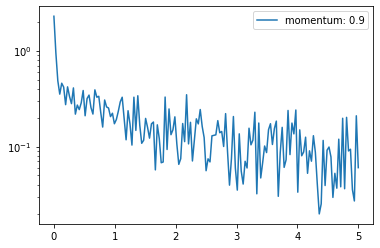

In [6]:
x_axis = np.linspace(0, 5, len(losses), endpoint=True)
plt.semilogy(x_axis, losses, label='momentum: 0.9')
plt.legend(loc='best')

我们可以对比一下不加动量的随机梯度下降法

In [8]:
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

optimizer = torch.optim.SGD(net.parameters(), lr=1e-2) # 不加动量
# 开始训练
losses1 = []
idx = 0
start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        if idx % 30 == 0: # 30 步记录一次
            losses1.append(loss.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.744894
epoch: 1, Train Loss: 0.365672
epoch: 2, Train Loss: 0.320343
epoch: 3, Train Loss: 0.292878
epoch: 4, Train Loss: 0.270102
使用时间: 33.97666 s


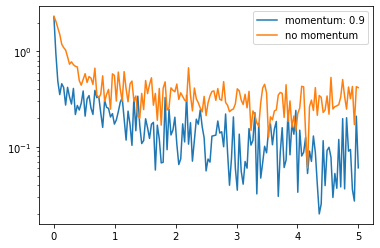

In [9]:
x_axis = np.linspace(0, 5, len(losses), endpoint=True)
plt.semilogy(x_axis, losses, label='momentum: 0.9')
plt.semilogy(x_axis, losses1, label='no momentum')
plt.legend(loc='best')

可以看到加完动量之后的 loss 下降的程度更低了，可以将动量理解为一种惯性作用，所以每次更新的幅度都会比不加动量的情况更多